In [ ]:
from google.colab import drive
from google.colab import files
import pandas as pd
import numpy as np
import networkx as nx
import time
import random
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, roc_auc_score

random.seed(42)
np.random.seed(42)

drive.mount('/content/drive')
dg_path = '/content/drive/MyDrive/DG-AssocMiner_miner-disease-gene.tsv'
df_disease = pd.read_csv(dg_path, sep='\t', comment='#', names=['Disease ID', 'Disease Name', 'Gene ID'])

target_disease = 'Salivary Gland Neoplasms'
positive_genes = df_disease[df_disease['Disease Name'] == target_disease]['Gene ID'].unique().astype(int)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
all_genes = df_disease['Gene ID'].unique().astype(int)
negative_genes = list(set(all_genes) - set(positive_genes))
negative_sample = np.random.choice(negative_genes, size=len(positive_genes), replace=False)

genes = list(positive_genes) + list(negative_sample)
labels = [1]*len(positive_genes) + [0]*len(negative_sample)
df_data = pd.DataFrame({'Gene ID': genes, 'Label': labels})

In [ ]:
biogrid_path = '/content/drive/MyDrive/BIOGRID-ALL-4.4.245.mitab.txt'
df_bg = pd.read_csv(biogrid_path, sep='\t', header=None, low_memory=False)

df_bg = df_bg[(df_bg[9].str.contains('taxid:9606')) & (df_bg[10].str.contains('taxid:9606'))]

def extract_gene_id(entry):
    try:
        if isinstance(entry, str) and 'entrez gene/locuslink:' in entry:
            return int(entry.split('entrez gene/locuslink:')[1].split('|')[0])
    except:
        return None
    return None

df_bg['GeneA'] = df_bg[0].apply(extract_gene_id)
df_bg['GeneB'] = df_bg[1].apply(extract_gene_id)
df_edges = df_bg[['GeneA', 'GeneB']].dropna().astype(int)

In [ ]:
G = nx.from_pandas_edgelist(df_edges, source='GeneA', target='GeneB')
G.remove_edges_from(nx.selfloop_edges(G))

nodes_of_interest = df_data['Gene ID'].unique()
nodes_of_interest = [node for node in nodes_of_interest if node in G]

betweenness = nx.betweenness_centrality(G, k=min(500, len(G)), seed=42)
closeness = {node: nx.closeness_centrality(G, node) for node in nodes_of_interest}
clustering = {node: nx.clustering(G, node) for node in nodes_of_interest}
pagerank = nx.pagerank(G)
kcore = nx.core_number(G)
degree_dict = dict(G.degree())

df_graph_features = pd.DataFrame({
    'Gene ID': list(nodes_of_interest),
    'Degree': [degree_dict.get(node, 0) for node in nodes_of_interest],
    'Betweenness': [betweenness.get(node, 0) for node in nodes_of_interest],
    'Closeness': [closeness.get(node, 0) for node in nodes_of_interest],
    'Clustering': [clustering.get(node, 0) for node in nodes_of_interest],
    'PageRank': [pagerank.get(node, 0) for node in nodes_of_interest],
    'Kcore': [kcore.get(node, 0) for node in nodes_of_interest]
})

df_data = df_data.merge(df_graph_features, on='Gene ID', how='left')

graph_cols = ['Degree', 'Betweenness', 'Closeness', 'Clustering', 'PageRank', 'Kcore']
df_data[graph_cols] = df_data[graph_cols].fillna(0)

positive_genes_str = [str(g) for g in positive_genes]
df_data['Gene ID str'] = df_data['Gene ID'].astype(str)
shortest_path_lengths = []

for gene in df_data['Gene ID str']:
    if gene not in G:
        shortest_path_lengths.append(-1)
        continue
    try:
        distances = [nx.shortest_path_length(G, source=gene, target=pg)
                     for pg in positive_genes_str if pg in G]
        shortest_path_lengths.append(min(distances) if distances else -1)
    except:
        shortest_path_lengths.append(-1)

df_data['ShortestPathToPositive'] = shortest_path_lengths
df_data.drop(columns=['Gene ID str'], inplace=True)

max_dist = df_data['ShortestPathToPositive'].replace(-1, pd.NA).max()
df_data['ShortestPathToPositive'] = df_data['ShortestPathToPositive'].replace(-1, max_dist + 1)

In [ ]:
df_data['Feature1'] = df_data['Gene ID'] % 1000
df_data['Feature2'] = (df_data['Gene ID'] // 1000) % 100

X = df_data[['Feature1', 'Feature2', 'Degree', 'ShortestPathToPositive', 'Betweenness', 'Closeness', 'Clustering', 'PageRank', 'Kcore']]
y = df_data['Label']
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['ShortestPathToPositive']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


In [ ]:
models = {
    'RandomForest': RandomForestClassifier(n_estimators=50, random_state=42),
    'SVM': SVC(probability=True, kernel='rbf', random_state=42),
    'kNearestNeighbors': KNeighborsClassifier(n_neighbors=4),
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'NaiveBayes': GaussianNB(),
    'ArtificialNN': MLPClassifier(hidden_layer_sizes=(50, 20), max_iter=5000, random_state=42)
}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

results = {'Model': [], 'Accuracy': [], 'AUROC': [], 'Train Time (s)': []}

for name, model in models.items():
    start = time.time()
    model.fit(X_train, y_train)
    end = time.time()

    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else model.decision_function(X_test)

    results['Model'].append(name)
    results['Accuracy'].append(accuracy_score(y_test, y_pred))
    results['AUROC'].append(roc_auc_score(y_test, y_prob))
    results['Train Time (s)'].append(end - start)

df_result = pd.DataFrame(results)
df_result

,Model,Accuracy,AUROC,Train Time (s)
0,RandomForest,0.444444,0.491667,0.111982
1,SVM,0.555556,0.516667,0.017806
2,kNearestNeighbors,0.481481,0.491667,0.022403
3,DecisionTree,0.518519,0.525000,0.001641
4,NaiveBayes,0.592593,0.727778,0.001151
5,ArtificialNN,0.555556,0.633333,0.491860


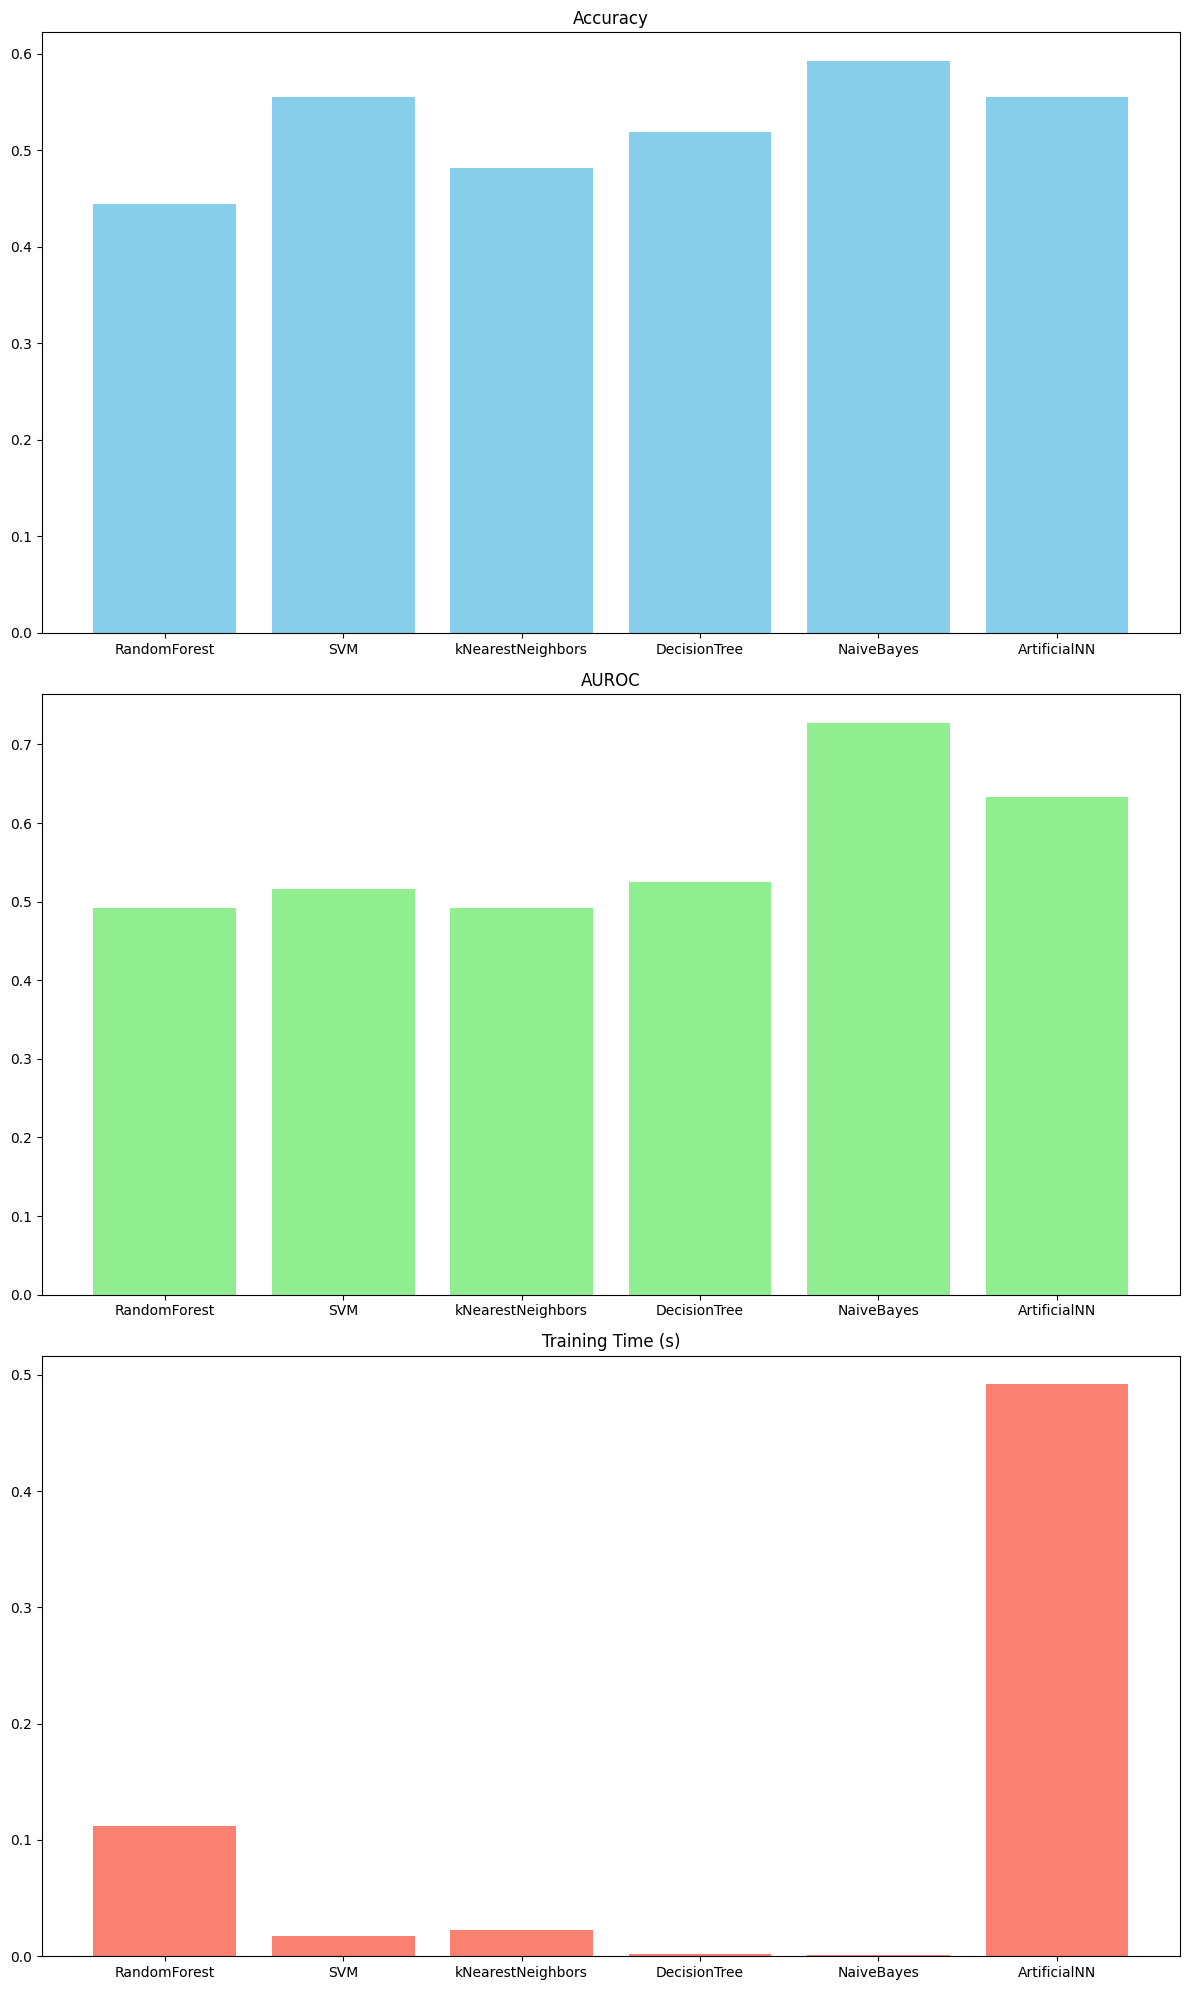

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 20))

axes[0].bar(df_result['Model'], df_result['Accuracy'], color='skyblue')
axes[0].set_title('Accuracy')

axes[1].bar(df_result['Model'], df_result['AUROC'], color='lightgreen')
axes[1].set_title('AUROC')

axes[2].bar(df_result['Model'], df_result['Train Time (s)'], color='salmon')
axes[2].set_title('Training Time (s)')

plt.tight_layout()
plt.show()